In [1]:
from torch.utils.data import Dataset,DataLoader
from PIL import Image
from tqdm import tqdm
from transformers import AutoProcessor, AutoModelForCausalLM, BlipForQuestionAnswering
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import pandas as pd
import matplotlib.pyplot as plt

https://gist.github.com/iamaziz/171170dce60d9cd07fab221507fd1d52

In [2]:
batch_size=4

In [3]:
#processor = AutoProcessor.from_pretrained("microsoft/git-base-textvqa")

In [4]:
processor = AutoProcessor.from_pretrained("microsoft/git-large-vqav2")
model = AutoModelForCausalLM.from_pretrained("microsoft/git-large-vqav2").to('cuda')
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

In [5]:
image_mean = processor.image_processor.image_mean
image_std = processor.image_processor.image_std

In [6]:
padding_len = 256
class VQADataset(torch.utils.data.Dataset):
    def __init__(self, data, processor):
        self.image = data['File_Name']
        self.questions = data['Question']
        self.answers = data['Answer']
        self.processor = processor

    def __len__(self):
        return self.image.shape[0]

    def __getitem__(self, idx):
        # get image + text
        answers = self.answers.tolist()[idx]
        text = self.questions.tolist()[idx]
        img_path = self.image.tolist()[idx]
        image = Image.open(img_path).convert("RGB")
        inputs = self.processor(images=image, text=text, max_length= padding_len, padding="max_length",truncation=True, return_tensors="pt")
        #print(inputs)

        # # remove batch dimension
        for k,v in inputs.items():
            inputs[k] = v.squeeze()
        # # add labels
        labels = self.processor.tokenizer.encode(
            answers,
            max_length= padding_len,
            padding="max_length",
            truncation=True,
            return_tensors='pt'
        )[0]
        inputs["labels"] = labels

        return inputs

In [7]:
df = pd.read_csv(r'./Data/metadata_pre.csv')
train_df=df[df['Image'].str.contains('train')]
val_df=df[df['Image'].str.contains('val')]
test_df=df[df['Image'].str.contains('test')]
train_df.shape[0]+val_df.shape[0]+test_df.shape[0]

32632

In [8]:
train_vqa_dataset = VQADataset(data=train_df,
                     processor = processor
                         )

val_vqa_dataset = VQADataset(data=val_df,
                     processor = processor
                         )

In [9]:
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    pixel_values = [item['pixel_values'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]
    # create new batch
    batch = {}
    batch['input_ids'] = torch.stack(input_ids)
    batch['attention_mask'] = torch.stack(attention_mask)
    batch['pixel_values'] = torch.stack(pixel_values)
    batch['labels'] = torch.stack(labels)

    return batch

train_dataloader = DataLoader(train_vqa_dataset,
                              collate_fn=collate_fn,
                              batch_size=2,
                              shuffle=False)
val_dataloader = DataLoader(val_vqa_dataset,
                            collate_fn=collate_fn,
                            batch_size=2,
                            shuffle=False)

In [10]:
train_vqa_dataset[0]

{'input_ids': tensor([  101,  2073,  2024, 11290,  7872,  4442,  1006,  9242,  4442,  1007,
         2284,  1029,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0, 

In [11]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k, v.shape)

input_ids torch.Size([2, 256])
attention_mask torch.Size([2, 256])
pixel_values torch.Size([2, 3, 420, 420])
labels torch.Size([2, 256])


Question:  [CLS] what are stained here with an immunohistochemical stain for cytokeratin 7? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

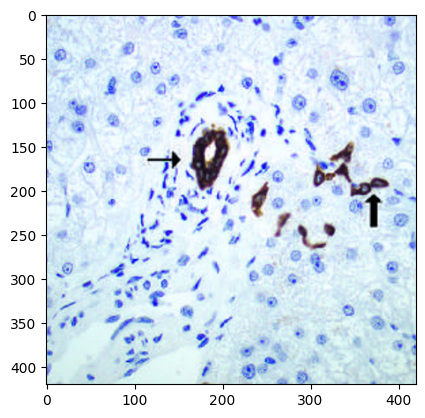

In [12]:
batch_idx = 1

unnormalized_image = (batch["pixel_values"][batch_idx].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)

print("Question: ",processor.decode(batch["input_ids"][batch_idx]))
print("Answer: ",processor.decode(batch["labels"][batch_idx]))
plt.imshow(Image.fromarray(unnormalized_image))

In [12]:
epoch_history_file = open(f"history_2.txt", "w")
epoch_history_file.write(f'epo \t train_loss\t val_loss\n')

# Fine-tuning loop
model.train()

for epoch in range(50):
    total_train_loss = 0.0
    train_dataloader = tqdm(train_dataloader, desc=f'Epo{epoch}', dynamic_ncols=True)  # Wrap the dataloader
    epoch_history_file = open(f"history_2.txt", "a")
    for batch in train_dataloader:
        input_ids, attention_mask, pixel_values = batch[0]['input_ids'].to('cuda'), batch[0]['attention_mask'].to('cuda'), batch[0]['pixel_values'].to('cuda')
        labels = batch[1].view(input_ids.shape[0], 512).to('cuda')
        #print(labels.shape)
        #print(attention_mask.shape)
        #print(pixel_values.shape)
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, pixel_values=pixel_values, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for batch in val_dataloader:
            input_ids, attention_mask, pixel_values = batch[0]['input_ids'].to('cuda'), batch[0]['attention_mask'].to('cuda'), batch[0]['pixel_values'].to('cuda')
            labels = batch[1].view(input_ids.shape[0], 512).to('cuda')

            # Forward pass to get model outputs
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, pixel_values=pixel_values, labels=labels)

            # Compute the loss using true labels
            val_loss += outputs.loss.item()
    epoch_history_file.write(f'{epoch}\t {total_train_loss / len(train_dataloader)}\t{val_loss / len(val_dataloader)}\n')
    epoch_history_file.close()
    #Save the fine-tuned model
    model.save_pretrained(f"GIT_textvqa_model_v2_epo{epoch}")
    print(f'Epo{epoch} | Trainloss: {round(total_train_loss / len(train_dataloader), 6)} | Valloss: {round(val_loss / len(val_dataloader), 6)}')

Epo0: 100%|████████████████████████████████████████████████████████████████████████| 4914/4914 [30:17<00:00,  2.70it/s]


Epo0 | Trainloss: 0.445105 | Valloss: 0.040455


Epo1: 100%|████████████████████████████████████████████████████████████████████████| 4914/4914 [29:05<00:00,  2.82it/s]


Epo1 | Trainloss: 0.037995 | Valloss: 0.038671


Epo2: 100%|████████████████████████████████████████████████████████████████████████| 4914/4914 [29:05<00:00,  2.82it/s]


Epo2 | Trainloss: 0.036015 | Valloss: 0.037826


Epo3: 100%|████████████████████████████████████████████████████████████████████████| 4914/4914 [29:05<00:00,  2.82it/s]


Epo3 | Trainloss: 0.034476 | Valloss: 0.0374


Epo4: 100%|████████████████████████████████████████████████████████████████████████| 4914/4914 [29:03<00:00,  2.82it/s]


Epo4 | Trainloss: 0.032922 | Valloss: 0.037524


Epo5: 100%|████████████████████████████████████████████████████████████████████████| 4914/4914 [29:03<00:00,  2.82it/s]


Epo5 | Trainloss: 0.031235 | Valloss: 0.037621


Epo6: 100%|████████████████████████████████████████████████████████████████████████| 4914/4914 [29:02<00:00,  2.82it/s]


Epo6 | Trainloss: 0.029615 | Valloss: 0.037878


Epo7: 100%|████████████████████████████████████████████████████████████████████████| 4914/4914 [29:01<00:00,  2.82it/s]


Epo7 | Trainloss: 0.028044 | Valloss: 0.037532


Epo8: 100%|████████████████████████████████████████████████████████████████████████| 4914/4914 [29:01<00:00,  2.82it/s]


Epo8 | Trainloss: 0.026579 | Valloss: 0.037877


Epo9: 100%|████████████████████████████████████████████████████████████████████████| 4914/4914 [29:31<00:00,  2.77it/s]


Epo9 | Trainloss: 0.025185 | Valloss: 0.037915


Epo10: 100%|███████████████████████████████████████████████████████████████████████| 4914/4914 [29:34<00:00,  2.77it/s]


Epo10 | Trainloss: 0.023851 | Valloss: 0.037736


Epo11: 100%|███████████████████████████████████████████████████████████████████████| 4914/4914 [29:33<00:00,  2.77it/s]


Epo11 | Trainloss: 0.022598 | Valloss: 0.037828


Epo12: 100%|███████████████████████████████████████████████████████████████████████| 4914/4914 [29:35<00:00,  2.77it/s]


Epo12 | Trainloss: 0.021369 | Valloss: 0.038222


Epo13: 100%|███████████████████████████████████████████████████████████████████████| 4914/4914 [29:32<00:00,  2.77it/s]


Epo13 | Trainloss: 0.020092 | Valloss: 0.038247


Epo14: 100%|███████████████████████████████████████████████████████████████████████| 4914/4914 [29:33<00:00,  2.77it/s]


Epo14 | Trainloss: 0.018865 | Valloss: 0.039481


Epo15: 100%|███████████████████████████████████████████████████████████████████████| 4914/4914 [29:32<00:00,  2.77it/s]


Epo15 | Trainloss: 0.017741 | Valloss: 0.039429


Epo16: 100%|███████████████████████████████████████████████████████████████████████| 4914/4914 [29:35<00:00,  2.77it/s]


Epo16 | Trainloss: 0.016606 | Valloss: 0.039299


Epo17: 100%|███████████████████████████████████████████████████████████████████████| 4914/4914 [29:28<00:00,  2.78it/s]


Epo17 | Trainloss: 0.01553 | Valloss: 0.040199


Epo18: 100%|███████████████████████████████████████████████████████████████████████| 4914/4914 [29:11<00:00,  2.80it/s]


Epo18 | Trainloss: 0.014451 | Valloss: 0.040725


Epo19: 100%|███████████████████████████████████████████████████████████████████████| 4914/4914 [29:16<00:00,  2.80it/s]


Epo19 | Trainloss: 0.013539 | Valloss: 0.041333


Epo20: 100%|███████████████████████████████████████████████████████████████████████| 4914/4914 [29:15<00:00,  2.80it/s]


Epo20 | Trainloss: 0.012646 | Valloss: 0.041321


Epo21: 100%|███████████████████████████████████████████████████████████████████████| 4914/4914 [29:13<00:00,  2.80it/s]


Epo21 | Trainloss: 0.012098 | Valloss: 0.042064


Epo22: 100%|███████████████████████████████████████████████████████████████████████| 4914/4914 [29:14<00:00,  2.80it/s]


Epo22 | Trainloss: 0.011201 | Valloss: 0.042785


Epo23: 100%|███████████████████████████████████████████████████████████████████████| 4914/4914 [29:14<00:00,  2.80it/s]


Epo23 | Trainloss: 0.010474 | Valloss: 0.042753


Epo24: 100%|███████████████████████████████████████████████████████████████████████| 4914/4914 [29:15<00:00,  2.80it/s]


Epo24 | Trainloss: 0.009967 | Valloss: 0.043575


Epo25: 100%|███████████████████████████████████████████████████████████████████████| 4914/4914 [28:54<00:00,  2.83it/s]


Epo25 | Trainloss: 0.009563 | Valloss: 0.044205


Epo26:   1%|▍                                                                        | 30/4914 [00:10<29:27,  2.76it/s]


KeyboardInterrupt: 